From Oliver Sange, Elias Huber and Sam Rouppe van der Voort

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## 3 Visualize Regularization Contours

x.shape: (2, 100), "y.shape:" (1, 100)


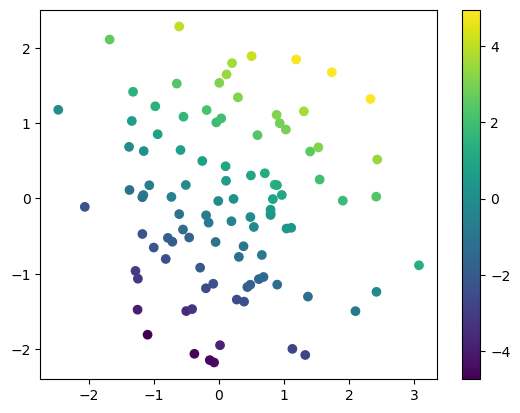

In [25]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'x.shape: {x.shape}, "y.shape:" {y.shape}')
plt.scatter(*x, c=y);
plt.colorbar()
plt.show()

In [26]:
# create a grid of points in the parameter space
b1, b2 = np.linspace(-1, 3, 101), np.linspace(-1, 3, 101)
bs = np.stack(np.meshgrid(b1, b2, indexing='ij'), axis=-1)
bs.shape

(101, 101, 2)

### (a)

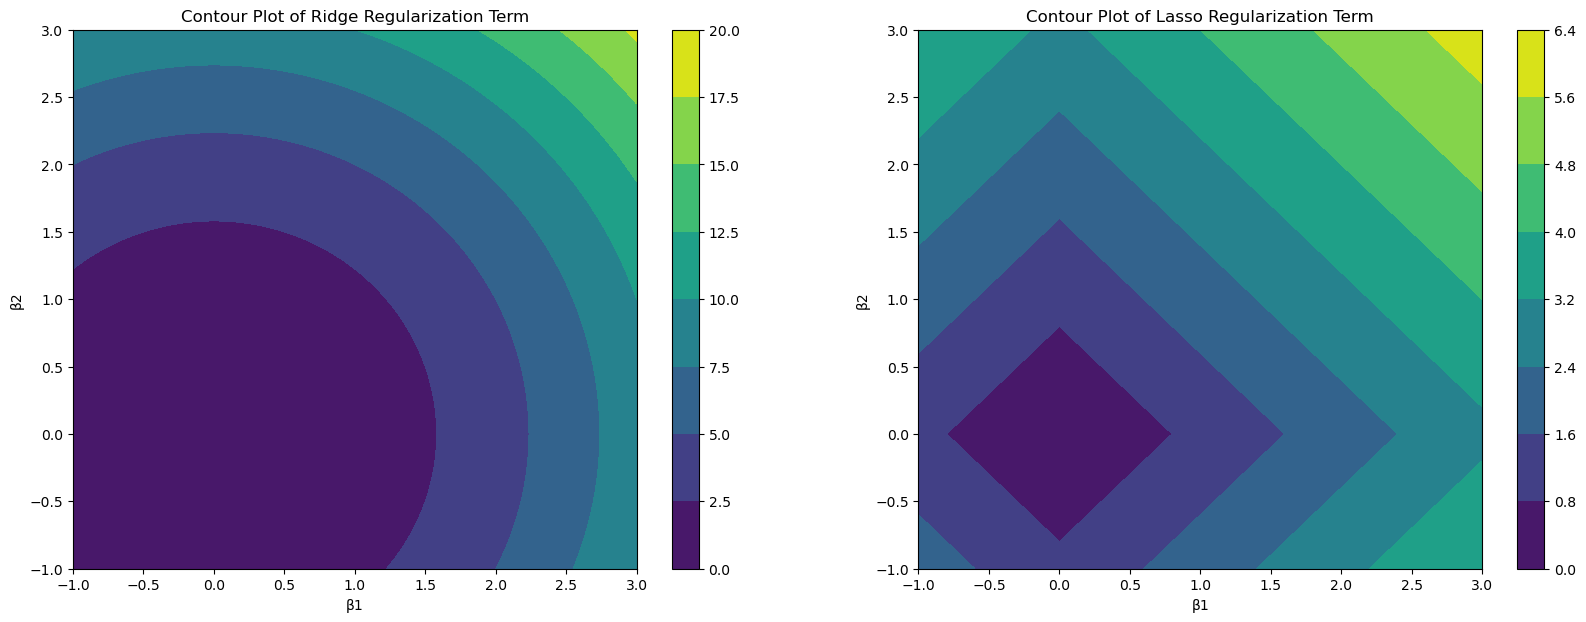

In [27]:
ridge_term = bs[..., 0]**2 + bs[..., 1]**2
lasso_term = np.abs(bs[..., 0]) + np.abs(bs[..., 1])

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Ridge regression
contour1 = ax[0].contourf(bs[..., 0], bs[..., 1], ridge_term, cmap='viridis')
fig.colorbar(contour1, ax=ax[0])
ax[0].set_title('Contour Plot of Ridge Regularization Term')
ax[0].set_xlabel('β1')
ax[0].set_ylabel('β2')

# Lasso regression
contour2 = ax[1].contourf(bs[..., 0], bs[..., 1], lasso_term, cmap='viridis')
fig.colorbar(contour2, ax=ax[1])
ax[1].set_title('Contour Plot of Lasso Regularization Term')
ax[1].set_xlabel('β1')
ax[1].set_ylabel('β2')

plt.show()

### (b)

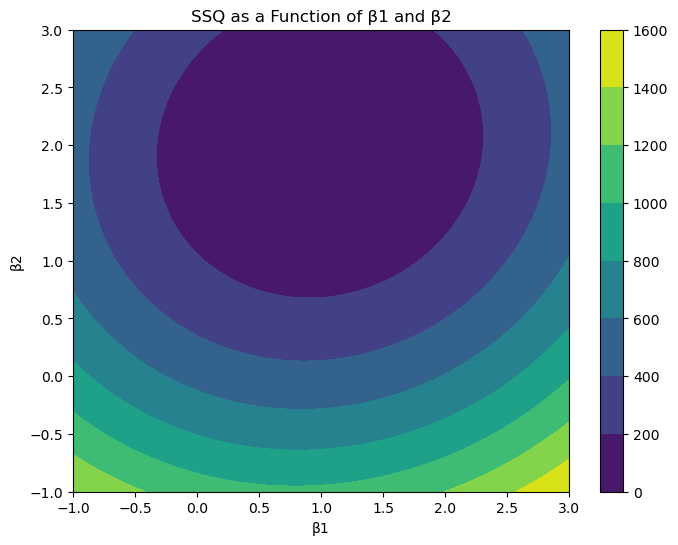

In [28]:
# Reshape bs
b1_vals = bs[..., 0]
b2_vals = bs[..., 1]

# Compute predictions
y_pred_grid = b1_vals[:, :, np.newaxis] * x[0] + b2_vals[:, :, np.newaxis] * x[1]

# Compute residuals
residuals = y - y_pred_grid 

# Compute SSQ
SSQ = np.sum(residuals**2, axis=-1)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(b1_vals, b2_vals, SSQ, cmap='viridis')
fig.colorbar(contour, ax=ax)
ax.set_title('SSQ as a Function of β1 and β2')
ax.set_xlabel('β1')
ax.set_ylabel('β2')
plt.show()

### (c)

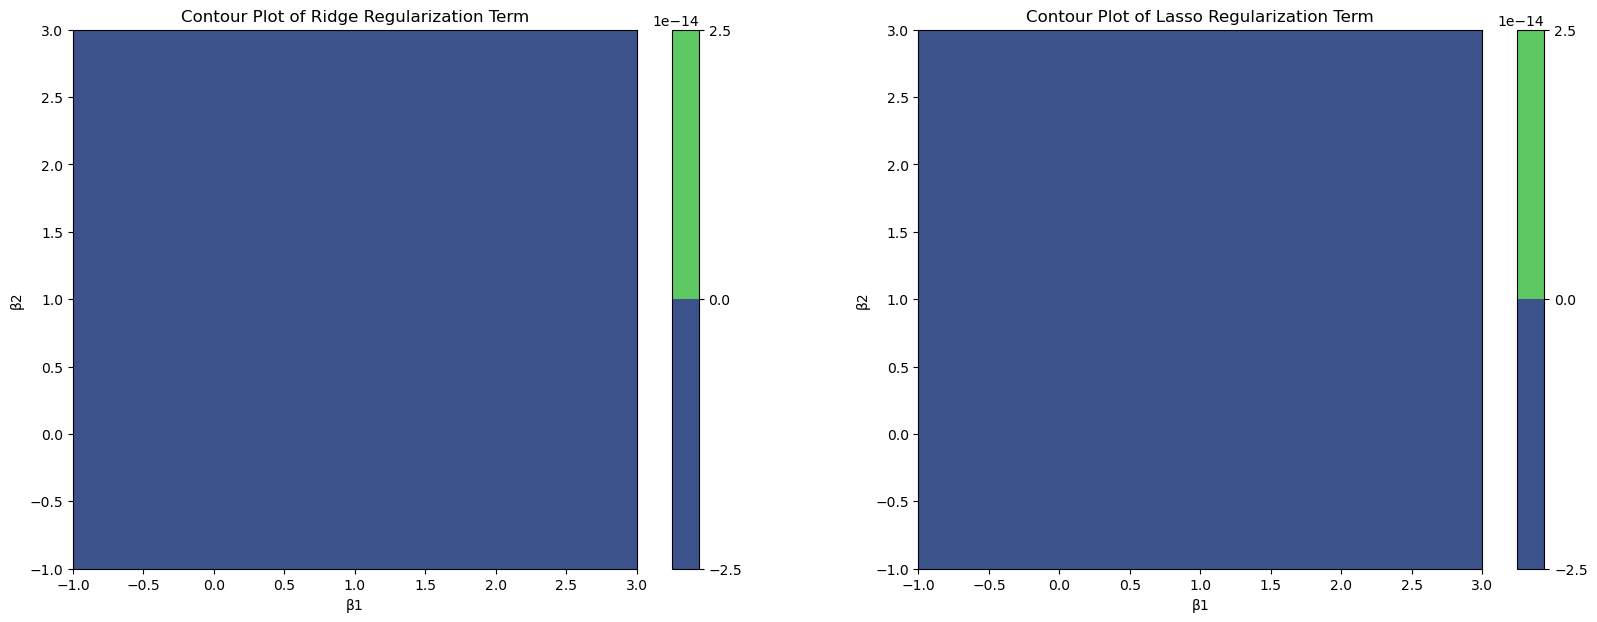

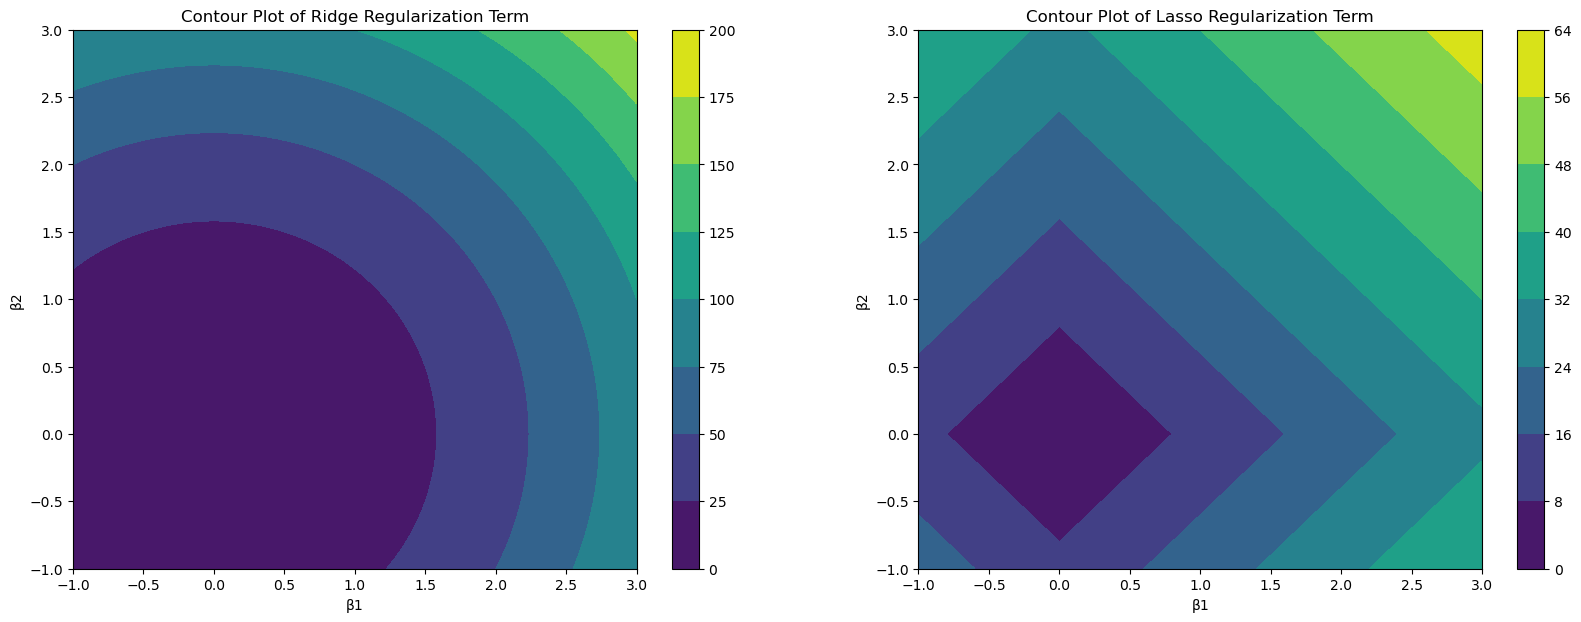

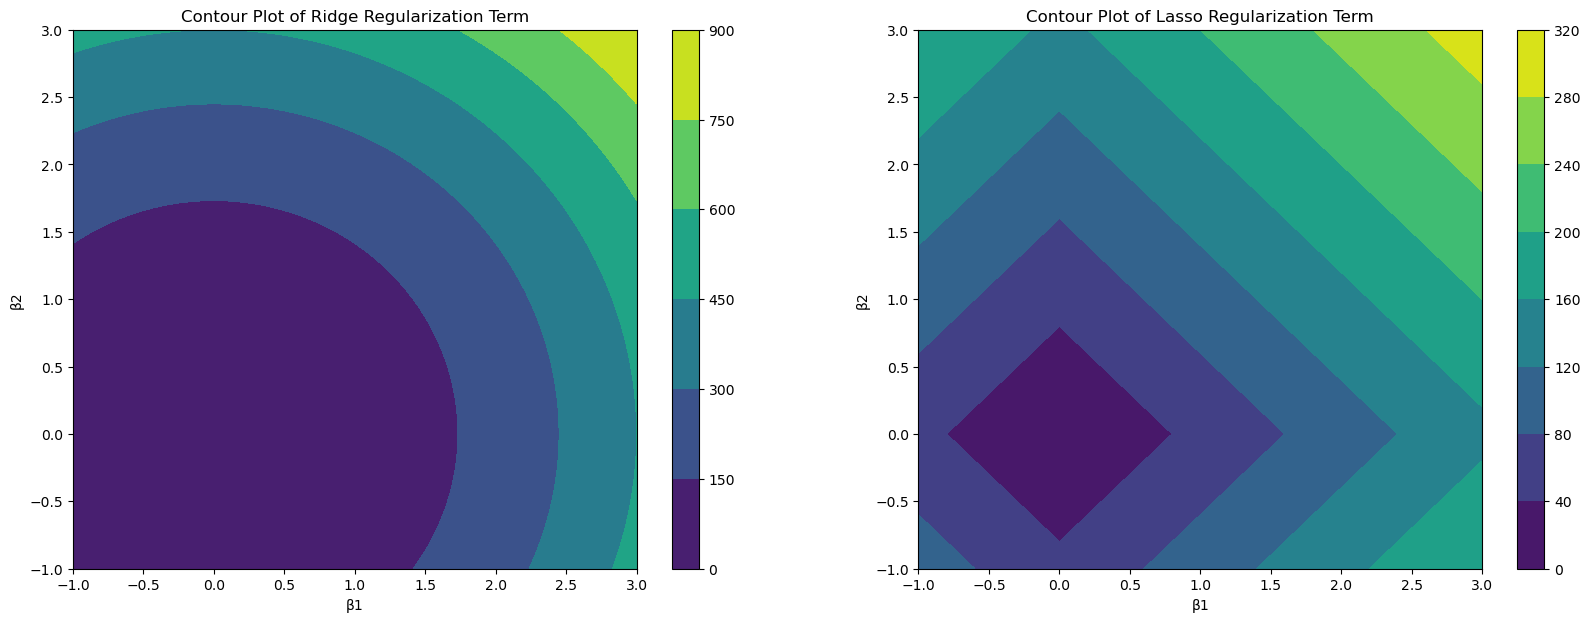

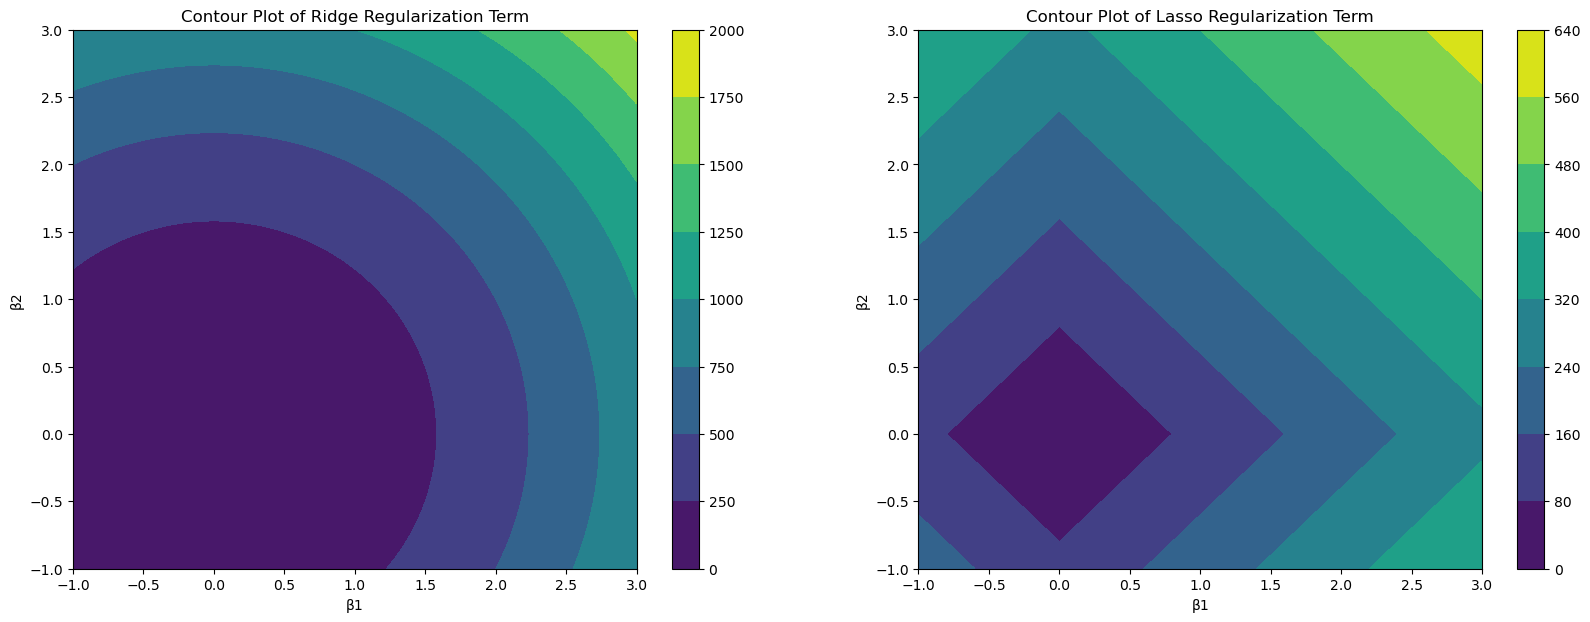

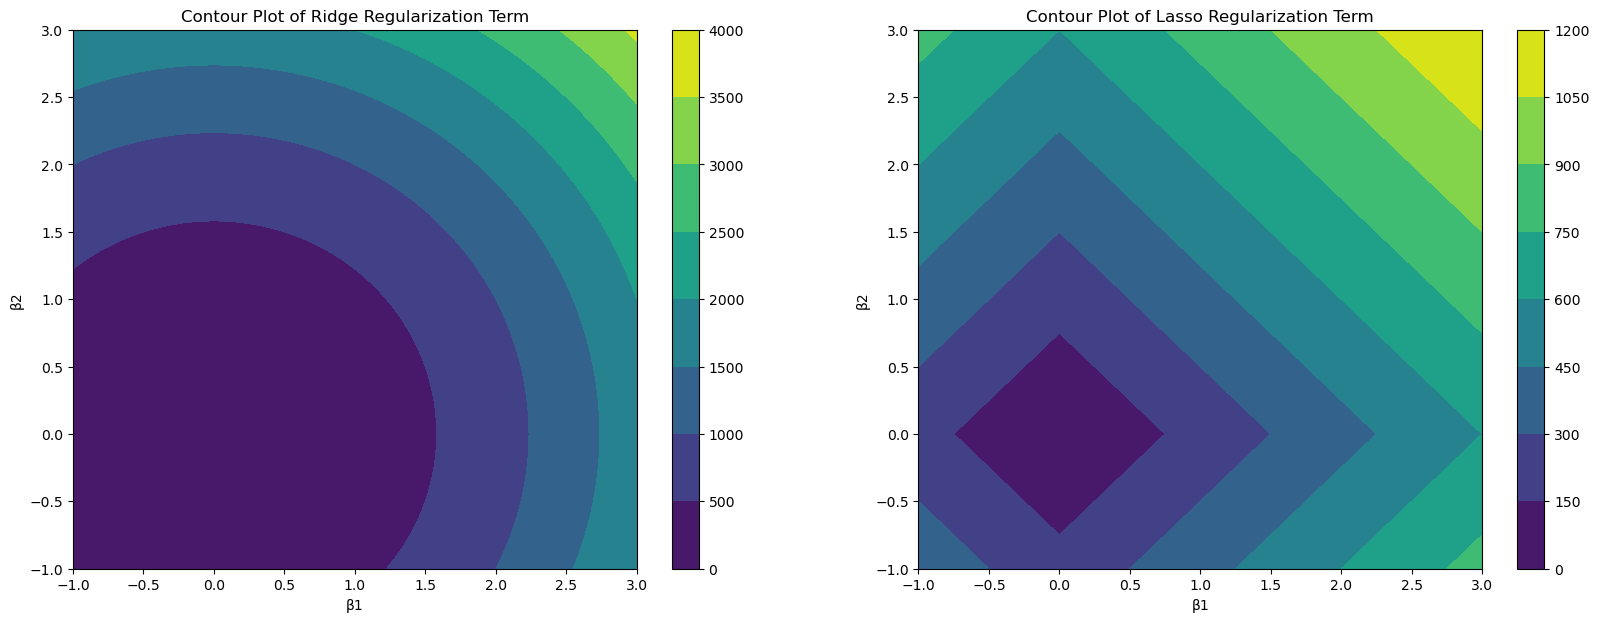

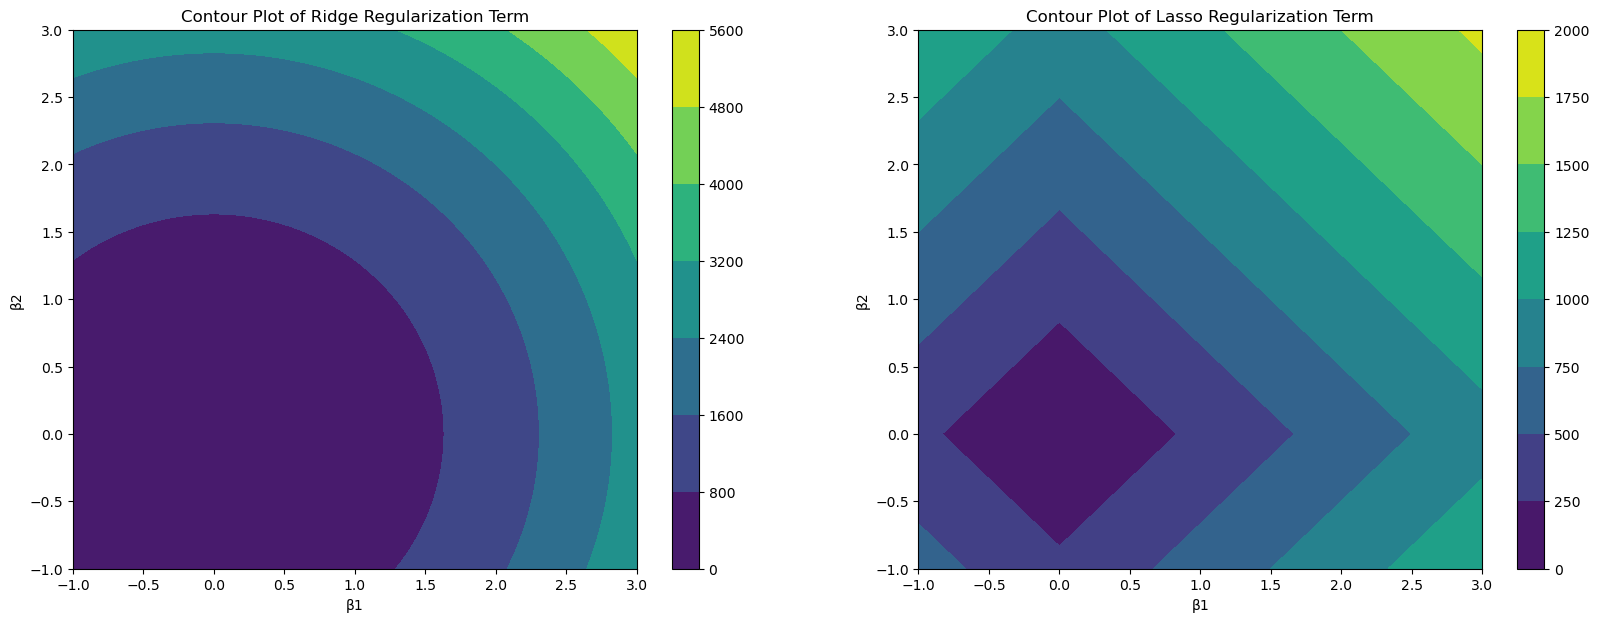

In [29]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]

for lam in lambdas:
    ridge_term = lam * (bs[..., 0]**2 + bs[..., 1]**2)
    lasso_term = lam * (np.abs(bs[..., 0]) + np.abs(bs[..., 1]))
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    # Ridge regression
    contour1 = ax[0].contourf(bs[..., 0], bs[..., 1], ridge_term, cmap='viridis')
    fig.colorbar(contour1, ax=ax[0])
    ax[0].set_title('Contour Plot of Ridge Regularization Term')
    ax[0].set_xlabel('β1')
    ax[0].set_ylabel('β2')
    
    # Lasso regression
    contour2 = ax[1].contourf(bs[..., 0], bs[..., 1], lasso_term, cmap='viridis')
    fig.colorbar(contour2, ax=ax[1])
    ax[1].set_title('Contour Plot of Lasso Regularization Term')
    ax[1].set_xlabel('β1')
    ax[1].set_ylabel('β2')
    
    plt.show()

For a larger λ, the colorbar will extend to higher values. This means that the colors in the plot will represent a stronger penalty, and the "cost" of larger coefficients beta1 and beta2 becomes more pronounced in the optimization.

## 4 CT Reconstruction

First, set up the design matrix. (Run this once to save it to the disk)

In [15]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

n_parallel_rays = 70 
n_ray_angles = 30
res = (99, 117)
print("Number of pixels in the 2d image:", np.prod(res))
print("Total number of rays:", n_parallel_rays * n_ray_angles)

def rot_mat(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

kernel = lambda x: np.exp(-x**2/sigma**2/2)

if not os.path.exists('data/design_matrix.npy'):
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 # np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles

    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

Number of pixels in the 2d image: 11583
Total number of rays: 2100


sino shape: (1, 2100)


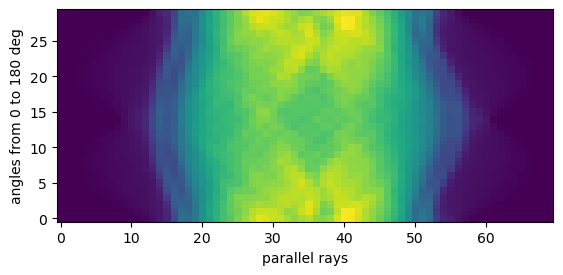

In [16]:
sino = np.load('data/sino.npy')

print(f'sino shape: {sino.shape}')

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower')
# plt.colorbar()
plt.xlabel('parallel rays')
plt.ylabel('angles from 0 to 180 deg')
plt.show();

### (a)

shape design matrix: (11583, 2100)


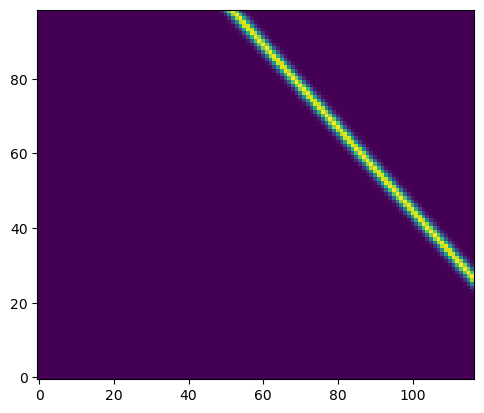

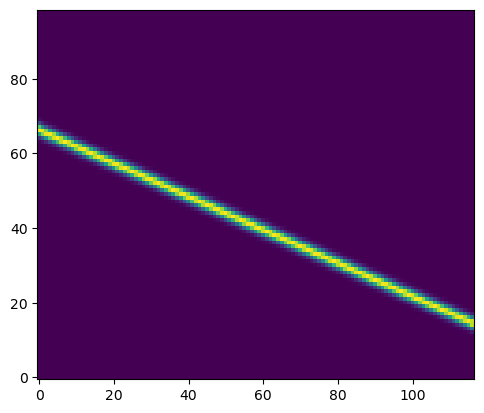

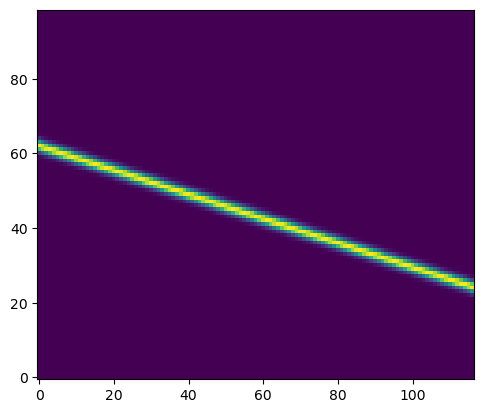

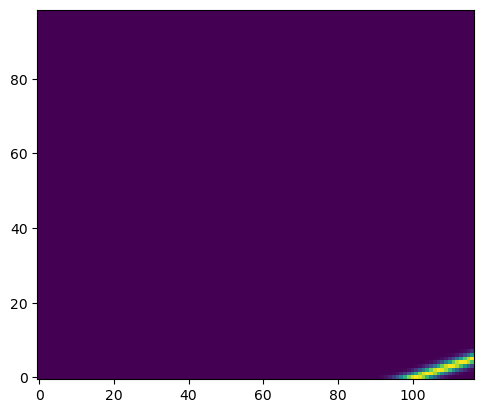

In [17]:
design_matrix = np.load('data/design_matrix.npy')
numbers = np.random.randint(0,design_matrix.shape[1],size = 4)
print(f"shape design matrix: {design_matrix.shape}")


image1 = design_matrix[:,numbers[0]].reshape(res)
image2 = design_matrix[:,numbers[1]].reshape(res)
image3 = design_matrix[:,numbers[2]].reshape(res)
image4 = design_matrix[:,numbers[3]].reshape(res)


plt.imshow(image1, origin='lower')
plt.show()
plt.imshow(image2, origin='lower')
plt.show()
plt.imshow(image3, origin='lower')
plt.show()
plt.imshow(image4, origin='lower')
plt.show()
# Each image shows the trajectory and its corresponding intensity through the final image


# TODO: visualize four random columns as images, using an image shape of (99, 117)

### (b)

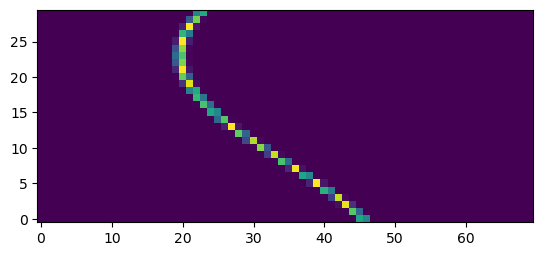

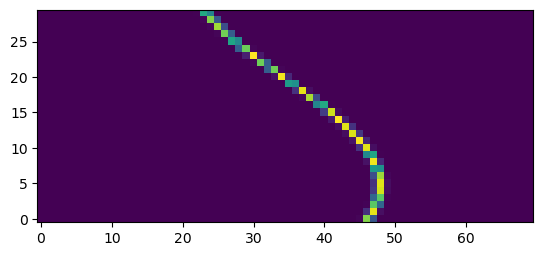

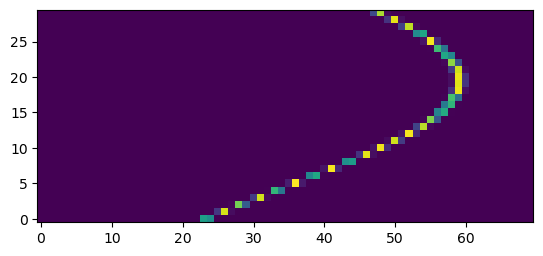

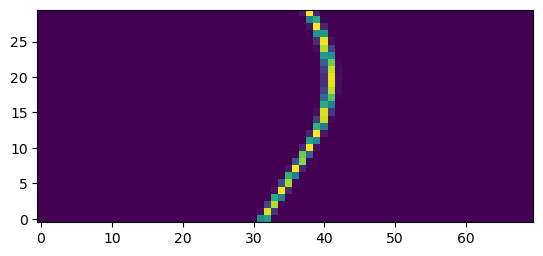

In [18]:
# TODO: visualize four random rows as images, using an images
numbers = np.random.randint(0,design_matrix.shape[0],size = 4)
res2 = (30,70)

image1 = design_matrix[numbers[0]].reshape(res2)
image2 = design_matrix[numbers[1]].reshape(res2)
image3 = design_matrix[numbers[2]].reshape(res2)
image4 = design_matrix[numbers[3]].reshape(res2)


plt.imshow(image1, origin='lower')
plt.show()
plt.imshow(image2, origin='lower')
plt.show()
plt.imshow(image3, origin='lower')
plt.show()
plt.imshow(image4, origin='lower')
plt.show()
# The images map the readout intensity of a detector to the corresponding ray and angle

### (c)

shapes: sino (1, 2100) design_matrix: (11583, 2100)
0.9999999900717896


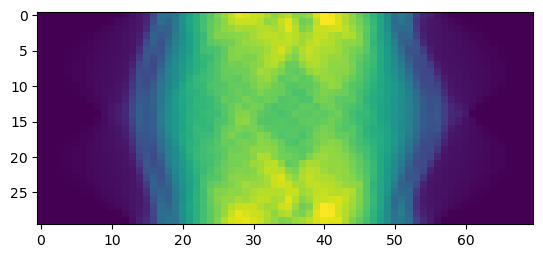

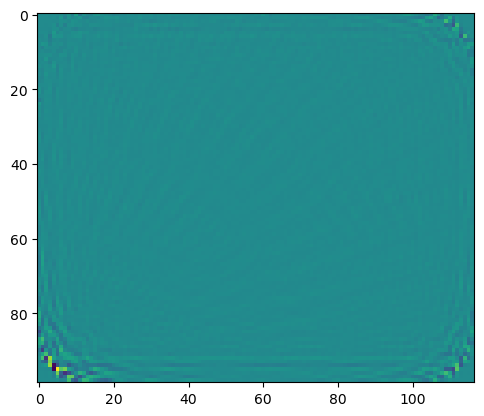

In [19]:
# TODO: solve the reconstruction with linear regression and visualize the result
print(f"shapes: sino {sino.shape} design_matrix: {design_matrix.shape}")
# project components onto sino
Y = sino.squeeze()
reg = LinearRegression().fit(design_matrix.T, Y)
print(reg.score(design_matrix.T,Y))
prediction = reg.predict(design_matrix.T)
new_sino = prediction.reshape((30,70))
plt.imshow(new_sino)
plt.show()
# double check if sinogram fits
image = reg.coef_.reshape(res)
plt.imshow(image)

# we observe that the reconstructed image is not interpretable

0.9999999710587341


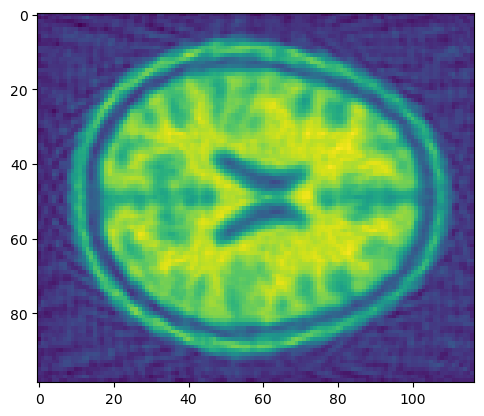

0.9999997054099179


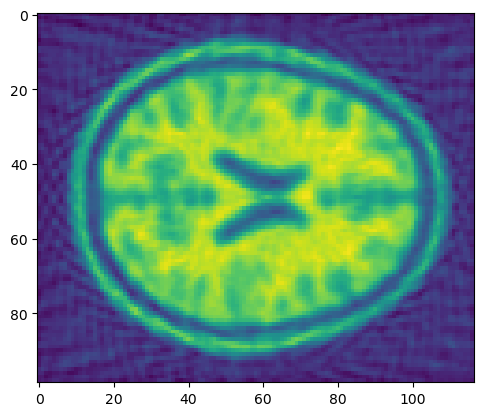

0.9999783629561321


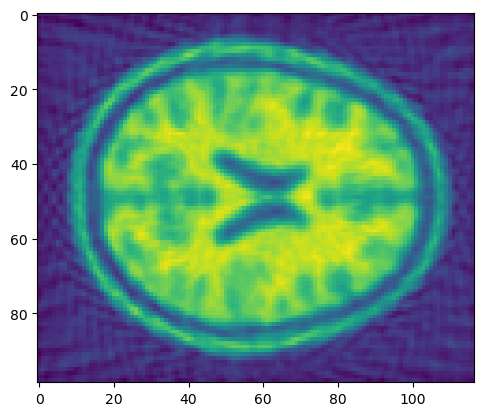

In [11]:
# TODO: solve the reconstruction with ridge regression and visualize the result
# Optional: try out different regularization strengths and observe the influence
from sklearn.linear_model import Ridge

reg = Ridge(alpha=0.1).fit(design_matrix.T, Y)
print(reg.score(design_matrix.T,Y))
prediction = reg.predict(design_matrix.T)
image = reg.coef_.reshape(res)
plt.imshow(image)
plt.show()

reg = Ridge(alpha=1).fit(design_matrix.T, Y)
print(reg.score(design_matrix.T,Y))
prediction = reg.predict(design_matrix.T)
image = reg.coef_.reshape(res)
plt.imshow(image)
plt.show()

reg = Ridge(alpha=10).fit(design_matrix.T, Y)
print(reg.score(design_matrix.T,Y))
prediction = reg.predict(design_matrix.T)
image = reg.coef_.reshape(res)
plt.imshow(image)
plt.show()

# We observe that alpha= 0.1 delivers the best image quality as well as the highest prediction score

## 5 Bonus: X-Ray Free-Electron Lasers

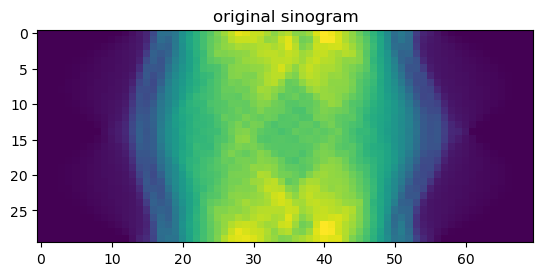

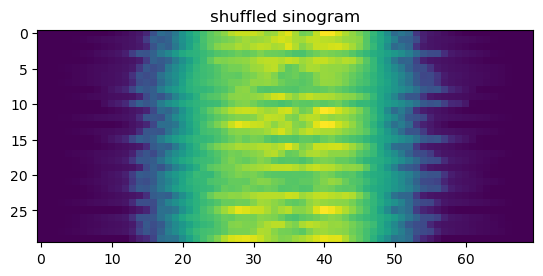

In [9]:
sino = np.load('data/sino.npy').reshape(n_angles, n_parallel_rays)
plt.imshow(sino)
plt.title('original sinogram')
plt.show()

order = np.arange(n_angles)
np.random.shuffle(order)
sino_shuffled = sino[order]
plt.imshow(sino_shuffled)
plt.title('shuffled sinogram')
plt.show()